In [1]:
import pandas as pd
import numpy as np

from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# MySQL table import

In [2]:
# Importa del archivo .env los datos de conexión a MySQl de forma segura
load_dotenv()
host = os.getenv('host')
database = os.getenv('database')
user = os.getenv('user')
port = os.getenv('port')
password = os.getenv('password')

In [3]:
# Crea la conexión a la base de datos MySQL utilizando la bublioteca SQLAlchemy
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}')

In [4]:
# Fuerza que se muestren todas las columnas de los dataframes
pd.set_option('display.max_columns', None)

# Importa la tabla limpia de MySQL accident
accident = pd.read_sql('SELECT * from final_project.accident', con=engine,dtype='object')

# Importa la tabla limpia de MySQL distract
distract = pd.read_sql('SELECT * from final_project.distract', con=engine,dtype='object')

# Importa la tabla limpia de MySQL drugs
drugs = pd.read_sql('SELECT * from final_project.drugs', con=engine,dtype='object')

# Importa la tabla limpia de MySQL maneuver
maneuver = pd.read_sql('SELECT * from final_project.maneuver', con=engine,dtype='object')

# Importa la tabla limpia de MySQL person
person = pd.read_sql('SELECT * from final_project.person', con=engine,dtype='object')

# Importa la tabla limpia de MySQL vehicle
vehicle = pd.read_sql('SELECT * from final_project.vehicle', con=engine,dtype='object')

# Importa la tabla limpia de MySQL weather
weather = pd.read_sql('SELECT * from final_project.weather', con=engine,dtype='object')

# ABT & final dataframe creation

### 'person' edition

In [5]:
# Elimina las columnas innecesarias de 'person'
columns_to_drop = ['ID', 'PER_NO', 'VEH_NO', 'TYPE_OF_PERSON', 'INJ_SEV', 'SEAT_POS', 'REST_MIS', 'HELM_MIS', 'DRINKING']
person = person.drop(columns=columns_to_drop)

In [6]:
# Convierte la columna categórica SEX en booleana
person = pd.get_dummies(person, columns = ['SEX', 'TYPE_OF_PERSONNAME', 'INJ_SEVNAME', 'SEAT_POSNAME', 'REST_MISNAME', 'HELM_MISNAME', 'DRINKINGNAME'])

In [7]:
# Crea una función que suma los 'True' de los valores booleanos
def true_sum(series):
    return series.sum()

In [8]:
# Agrupa la tabla 'person' creando medias según la edad de todos los pasajeros en cada accidente y completa con 0 o 1 el resto de valores categóricos
person = person.groupby('ST_CASE').agg({'AGE':'mean', 'SEX_Female':true_sum, 'SEX_Male':true_sum, 'SEX_Unknown':true_sum, 'TYPE_OF_PERSONNAME_Bicyclist':true_sum,\
    'TYPE_OF_PERSONNAME_Bicyclist or similar':true_sum, 'TYPE_OF_PERSONNAME_Driver':true_sum, 'TYPE_OF_PERSONNAME_Occupant parked vehicle':true_sum, 'TYPE_OF_PERSONNAME_Passenger':true_sum,\
        'TYPE_OF_PERSONNAME_Pedestrian':true_sum, 'TYPE_OF_PERSONNAME_Person in a building':true_sum, 'TYPE_OF_PERSONNAME_Unknown':true_sum, 'INJ_SEVNAME_Died Prior to Crash':true_sum,\
            'INJ_SEVNAME_Fatal Injury':true_sum, 'INJ_SEVNAME_Injured, Severity Unknown':true_sum, 'INJ_SEVNAME_No Apparent Injury':true_sum, 'INJ_SEVNAME_Possible Injury':true_sum,\
                'INJ_SEVNAME_Suspected Minor Injury':true_sum, 'INJ_SEVNAME_Suspected Serious Injury':true_sum, 'INJ_SEVNAME_Unknown/Not Reported':true_sum, 'SEAT_POSNAME_Back':true_sum,\
                    'SEAT_POSNAME_Back left':true_sum, 'SEAT_POSNAME_Back middle':true_sum, 'SEAT_POSNAME_Back right':true_sum, 'SEAT_POSNAME_Front':true_sum, 'SEAT_POSNAME_Front left':true_sum,\
                        'SEAT_POSNAME_Front middle':true_sum, 'SEAT_POSNAME_Front right':true_sum, 'SEAT_POSNAME_Not regular vehicle':true_sum, 'SEAT_POSNAME_Unknown':true_sum, 'REST_MISNAME_No Indication of Misuse':true_sum,\
                            'REST_MISNAME_None Used/Not Applicable':true_sum, 'REST_MISNAME_Not a Motor Vehicle Occupant':true_sum, 'REST_MISNAME_Yes, Indication of Misuse':true_sum,\
                                'HELM_MISNAME_No Indication of Misuse':true_sum, 'HELM_MISNAME_None Used/Not Applicable':true_sum, 'HELM_MISNAME_Not a Motor Vehicle Occupant':true_sum,\
                                    'HELM_MISNAME_Yes, Indication of Misuse':true_sum, 'DRINKINGNAME_No (Alcohol Not Involved)':true_sum,'DRINKINGNAME_Not Reported':true_sum, 'DRINKINGNAME_Reported as Unknown':true_sum,\
                                        'DRINKINGNAME_Yes (Alcohol Involved)':true_sum}).reset_index()

In [9]:
# Elimina las columnas innecesarias de 'person'
columns_to_drop = ['SEX_Unknown', 'TYPE_OF_PERSONNAME_Unknown', 'INJ_SEVNAME_Unknown/Not Reported', 'SEAT_POSNAME_Unknown', 'REST_MISNAME_No Indication of Misuse', 'REST_MISNAME_None Used/Not Applicable',\
    'REST_MISNAME_Not a Motor Vehicle Occupant', 'HELM_MISNAME_No Indication of Misuse', 'HELM_MISNAME_None Used/Not Applicable', 'HELM_MISNAME_Not a Motor Vehicle Occupant', 'DRINKINGNAME_No (Alcohol Not Involved)',\
        'DRINKINGNAME_Not Reported', 'DRINKINGNAME_Reported as Unknown']
person = person.drop(columns=columns_to_drop)

In [10]:
person = person.rename(columns={'AGE':'Age', 'SEX_Female':'Female', 'SEX_Male':'Male', 'TYPE_OF_PERSONNAME_Bicyclist':'Bicyclist', 'TYPE_OF_PERSONNAME_Bicyclist or similar':'Similar_To_Bicyclist',\
    'TYPE_OF_PERSONNAME_Driver':'Driver', 'TYPE_OF_PERSONNAME_Occupant parked vehicle':'Occupant_Parked_Vehicle', 'TYPE_OF_PERSONNAME_Passenger':'Passenger', 'TYPE_OF_PERSONNAME_Pedestrian':'Pedestrian',\
        'TYPE_OF_PERSONNAME_Person in a building':'Person_In_A_Building', 'INJ_SEVNAME_Died Prior to Crash':'Died_Prior_To_Crash', 'INJ_SEVNAME_Fatal Injury':'Fatal_Injury',\
            'INJ_SEVNAME_Injured, Severity Unknown': 'Injured_Severity_Unknown', 'INJ_SEVNAME_Injured,\Severity Unknown':'Injured_Severity_Unknown', 'INJ_SEVNAME_No Apparent Injury':'No_Apparent_Injury',\
                'INJ_SEVNAME_Possible Injury':'Possible_Injury', 'INJ_SEVNAME_Suspected Minor Injury':'Suspected_Minor_Injury', 'INJ_SEVNAME_Suspected Serious Injury':'Suspected_Serious_Injury', 'SEAT_POSNAME_Back':'Seat_Back',\
                    'SEAT_POSNAME_Back left':'Seat_Back_Left', 'SEAT_POSNAME_Back middle':'Seat_Back_Middle', 'SEAT_POSNAME_Back right':'Seat_Back_Right', 'SEAT_POSNAME_Front':'Seat_Front',\
                        'SEAT_POSNAME_Front left':'Seat_Front_Left', 'SEAT_POSNAME_Front middle':'Seat_Front_Middle', 'SEAT_POSNAME_Front right':'Seat_Front_Right', 'SEAT_POSNAME_Not regular vehicle':'Seat_Not_Regular_Vehicle',\
                            'REST_MISNAME_Yes, Indication of Misuse':'Restraint_Misuse', 'HELM_MISNAME_Yes, Indication of Misuse':'Helm_Misuse', 'DRINKINGNAME_Yes (Alcohol Involved)':'Drinking_Involved'})

<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:4: SyntaxWarning: invalid escape sequence '\S'
C:\Users\perez\AppData\Local\Temp\ipykernel_13476\2662490717.py:4: SyntaxWarning: invalid escape sequence '\S'
  'INJ_SEVNAME_Injured, Severity Unknown': 'Injured_Severity_Unknown', 'INJ_SEVNAME_Injured,\Severity Unknown':'Injured_Severity_Unknown', 'INJ_SEVNAME_No Apparent Injury':'No_Apparent_Injury',\


### 'vehicle' edition

In [11]:
# Elimina las columnas innecesarias de 'vehicle'
columns_to_drop = ['ID', 'VEH_NO', 'VEHICLE_TYPE', 'VEHICLE_MANUFACTURER',  'VEHICLE_MANUFACTURERNAME', 'VEHICLE_MODEL', 'VEHICLE_MODELNAME', 'VEHICLE_CLASS', 'VEHICLE_CLASSNAME', 'VEHICLE_WEIGHT', 'BUS_USE', 'BUS_USENAME',\
    'SPEC_USE', 'SPEC_USENAME', 'EMER_USE', 'EMER_USENAME', 'NUMOCCS', 'ROLLOVER', 'ROLLOVERNAME', 'ROLINLOC', 'ROLINLOCNAME', 'IMPACT1', 'TOWED', 'TOWEDNAME', 'ROAD_CONDITION', 'ACC_TYPE', 'DRIVERS_PRESENCE',\
        'DRIVERS_PRESENCENAME', 'LICENSE_COMPLIANCE', 'LICENSE_RESTRICTION', 'SPEEDREL', 'HIT_RUN']
vehicle = vehicle.drop(columns=columns_to_drop)

In [12]:
# Convierte las columnas categóricas en booleanas
vehicle = pd.get_dummies(vehicle, columns = ['VEHICLE_TYPENAME', 'VEHICLE_WEIGHTNAME', 'IMPACT1NAME', 'ROAD_CONDITIONNAME', 'ACC_TYPENAME', 'LICENSE_COMPLIANCENAME', 'LICENSE_RESTRICTIONNAME', 'SPEEDRELNAME', 'HIT_RUNNAME'])

In [13]:
# Filtra los valores de 'PREVIOUS_ACCIDENT' de 'vehicle' para eliminar los outliers que son posiblemente errores
vehicle = vehicle[(vehicle['PREVIOUS_ACCIDENT'] < 50)]

In [14]:
# Filtra los valores de MOD_YEAR entre 1900 y 2022
vehicle = vehicle[(vehicle['MOD_YEAR'] >= 1900) & (vehicle['MOD_YEAR'] <= 2022)]

In [15]:
# Elimina las columnas innecesarias de 'vehicle'
columns_to_drop = ['VEHICLE_TYPENAME_Not Reported', 'VEHICLE_WEIGHTNAME_Unknown', 'IMPACT1NAME_Unknown', 'ROAD_CONDITIONNAME_Unknown', 'ACC_TYPENAME_Specifics Unknown', 'ACC_TYPENAME_Unknown', 'LICENSE_COMPLIANCENAME_Unknown',\
    'LICENSE_COMPLIANCENAME_Valid license for this class vehicle', 'LICENSE_RESTRICTIONNAME_Restrictions Complied With', 'LICENSE_RESTRICTIONNAME_Restrictions, Compliance Unknown', 'LICENSE_RESTRICTIONNAME_Unknown',\
        'SPEEDRELNAME_Unknown']
vehicle = vehicle.drop(columns=columns_to_drop)

In [16]:
# Agrupa la tabla 'vehicle' creando medias de todos los valores numéricos y completa con 0 o 1 los valores categóricos
vehicle = vehicle.groupby('ST_CASE').agg({'MOD_YEAR':'mean', 'PREVIOUS_ACCIDENT':'mean', 'PREVIOUS_SUSPENSION':'mean', 'PREVIOUS_DRIVING_WHILE_INTOXIDATED':'mean', 'PREVIOUS_SPEED_CONVICT':'mean',\
    'VEHICLE_TYPENAME_2-door sedan':true_sum, 'VEHICLE_TYPENAME_All-Terrain Cycle':true_sum, 'VEHICLE_TYPENAME_Body type':true_sum, 'VEHICLE_TYPENAME_Bus':true_sum, 'VEHICLE_TYPENAME_Cab Chassis Based':true_sum,\
        'VEHICLE_TYPENAME_Compact Utility':true_sum, 'VEHICLE_TYPENAME_Convertible':true_sum, 'VEHICLE_TYPENAME_Coupe':true_sum, 'VEHICLE_TYPENAME_Golf Cart':true_sum, 'VEHICLE_TYPENAME_Large utility':true_sum,\
            'VEHICLE_TYPENAME_Low Speed Vehicle':true_sum, 'VEHICLE_TYPENAME_Minivan':true_sum, 'VEHICLE_TYPENAME_Moped':true_sum, 'VEHICLE_TYPENAME_Motor Scooter':true_sum, 'VEHICLE_TYPENAME_Motor home':true_sum,\
                'VEHICLE_TYPENAME_Motorcycle':true_sum, 'VEHICLE_TYPENAME_Motored cycle type':true_sum, 'VEHICLE_TYPENAME_Pickup':true_sum, 'VEHICLE_TYPENAME_Recreational Off-Highway Vehicle':true_sum,\
                    'VEHICLE_TYPENAME_School Bus':true_sum, 'VEHICLE_TYPENAME_Sedan':true_sum, 'VEHICLE_TYPENAME_Snowmobile':true_sum, 'VEHICLE_TYPENAME_Solar electric':true_sum, 'VEHICLE_TYPENAME_Station Wagon':true_sum,\
                        'VEHICLE_TYPENAME_Truck':true_sum, 'VEHICLE_TYPENAME_Truck-tractor':true_sum, 'VEHICLE_TYPENAME_Utility vehicle':true_sum, 'VEHICLE_TYPENAME_Van':true_sum, 'VEHICLE_TYPENAME_Van-Based Bus GVWR':true_sum,\
                            'VEHICLE_WEIGHTNAME_11,794 - 14,969 kg':true_sum, 'VEHICLE_WEIGHTNAME_14,969 kg and above':true_sum, 'VEHICLE_WEIGHTNAME_2,722 - 4,536 kg':true_sum, 'VEHICLE_WEIGHTNAME_2,722 kg or less':true_sum,\
                                'VEHICLE_WEIGHTNAME_4,536 - 6,350 kg':true_sum, 'VEHICLE_WEIGHTNAME_6,350 - 7,258 kg':true_sum, 'VEHICLE_WEIGHTNAME_7,258 - 8,845 kg':true_sum, 'VEHICLE_WEIGHTNAME_8,845 - 11,794 kg':true_sum,\
                                    'IMPACT1NAME_Back':true_sum, 'IMPACT1NAME_Front':true_sum, 'IMPACT1NAME_Left':true_sum, 'IMPACT1NAME_Left-Back':true_sum, 'IMPACT1NAME_Left-Front':true_sum,\
                                        'IMPACT1NAME_Non-Collision':true_sum, 'IMPACT1NAME_Right':true_sum, 'IMPACT1NAME_Right-Back':true_sum, 'IMPACT1NAME_Right-Front':true_sum, 'IMPACT1NAME_Top':true_sum,\
                                            'IMPACT1NAME_Undercarriage':true_sum, 'IMPACT1NAME_Vehicle, Objects or Person Set-in-motion':true_sum, 'ROAD_CONDITIONNAME_Dry':true_sum, 'ROAD_CONDITIONNAME_Ice':true_sum,\
                                                'ROAD_CONDITIONNAME_Mud, Dirt or Gravel':true_sum, 'ROAD_CONDITIONNAME_Non-Trafficway':true_sum, 'ROAD_CONDITIONNAME_Oil':true_sum, 'ROAD_CONDITIONNAME_Snow':true_sum,\
                                                    'ROAD_CONDITIONNAME_Water':true_sum, 'ROAD_CONDITIONNAME_Wet':true_sum, 'ACC_TYPENAME_Avoid Collision With Object':true_sum,\
                                                        'ACC_TYPENAME_Avoid Collision With Veh., Ped., Anim.':true_sum, 'ACC_TYPENAME_Avoid Collision With Vehicle':true_sum,\
                                                            'ACC_TYPENAME_Avoid Collision with Vehicle':true_sum, 'ACC_TYPENAME_Backing Veh.':true_sum, 'ACC_TYPENAME_Changing Lanes to the Left':true_sum,\
                                                                'ACC_TYPENAME_Changing Lanes to the Right':true_sum, 'ACC_TYPENAME_Control/Traction Loss':true_sum, 'ACC_TYPENAME_Decelerating (Slowing)':true_sum,\
                                                                    'ACC_TYPENAME_Decelerating (Slowing), Going Left':true_sum, 'ACC_TYPENAME_Decelerating (Slowing), Going Right':true_sum,\
                                                                        'ACC_TYPENAME_Decelerating (Slowing), Going Straight':true_sum, 'ACC_TYPENAME_Drive Off Road':true_sum, 'ACC_TYPENAME_End Departure':true_sum,\
                                                                            'ACC_TYPENAME_Initial Opposite Directions (Going Straight)':true_sum, 'ACC_TYPENAME_Initial Opposite Directions (Left/Right)':true_sum,\
                                                                                'ACC_TYPENAME_Initial Same Directions (Going Straight)':true_sum, 'ACC_TYPENAME_Initial Same Directions (Turning Left)':true_sum,\
                                                                                    'ACC_TYPENAME_Initial Same Directions (Turning Right)':true_sum, 'ACC_TYPENAME_Lateral Move (Going Straight)':true_sum,\
                                                                                        'ACC_TYPENAME_Lateral Move (Left/Right)':true_sum, 'ACC_TYPENAME_No Impact':true_sum, 'ACC_TYPENAME_Other Crash Type':true_sum,\
                                                                                            'ACC_TYPENAME_Other Vehicle':true_sum, 'ACC_TYPENAME_Parked Veh.':true_sum, 'ACC_TYPENAME_Pedestrian/ Animal':true_sum,\
                                                                                                'ACC_TYPENAME_Slower':true_sum, 'ACC_TYPENAME_Slower, Going Left':true_sum, 'ACC_TYPENAME_Slower, Going Right':true_sum,\
                                                                                                    'ACC_TYPENAME_Slower, Going Straight':true_sum, 'ACC_TYPENAME_Specifics Other':true_sum, 'ACC_TYPENAME_Sta. Object':true_sum,\
                                                                                                        'ACC_TYPENAME_Stopped':true_sum, 'ACC_TYPENAME_Straight Ahead on Left':true_sum,\
                                                                                                            'ACC_TYPENAME_Straight Ahead on Left/Right':true_sum, 'ACC_TYPENAME_Striking from the Left':true_sum,\
                                                                                                                'ACC_TYPENAME_Striking from the Right':true_sum, 'ACC_TYPENAME_Struck on the Right':true_sum,\
                                                                                                                    'ACC_TYPENAME_Struck on the left':true_sum,\
                                                                                                                        'ACC_TYPENAME_Turn Into Opposite Directions (Going Straight)':true_sum,\
                                                                                                                            'ACC_TYPENAME_Turn Into Opposite Directions (Turning Left)':true_sum,\
                                                                                                                                'ACC_TYPENAME_Turn Into Opposite Directions (Turning Right)':true_sum,\
                                                                                                                                    'ACC_TYPENAME_Turn Into Same Direction (Going Straight)':true_sum,\
                                                                                                                                        'ACC_TYPENAME_Turn Into Same Direction (Turning Left)':true_sum,\
                                                                                                                                            'ACC_TYPENAME_Turn Into Same Direction (Turning Right)':true_sum,\
                                                                                                                                                'LICENSE_COMPLIANCENAME_No Driver Present/Unknown if Driver Present':true_sum,\
                                                                                                                                                    'LICENSE_COMPLIANCENAME_No license required for this class vehicle':true_sum,\
                                                                                                                                                        'LICENSE_COMPLIANCENAME_No valid license for this class vehicle':true_sum,\
                                                                                                                                                            'LICENSE_COMPLIANCENAME_Not licensed':true_sum,\
                                                                                                                                                                'LICENSE_RESTRICTIONNAME_No Driver Present/Unknown if Driver Present':true_sum,\
                                                                                                                                                                    'LICENSE_RESTRICTIONNAME_No Restrictions or Not Applicable':true_sum,\
                                                                                                                                                                        'LICENSE_RESTRICTIONNAME_Restrictions Not Complied With':true_sum,\
                                                                                                                                                                            'SPEEDRELNAME_No':true_sum, 'SPEEDRELNAME_Yes':true_sum,\
                                                                                                                                                                                'HIT_RUNNAME_No':true_sum, 'HIT_RUNNAME_Yes':true_sum})\
                                                                                                                                                                                    .reset_index()

In [17]:
vehicle = vehicle.rename(columns={'MOD_YEAR':'Model_Year', 'PREVIOUS_ACCIDENT':'Previous_Accident', 'PREVIOUS_SUSPENSION':'Previous_Suspension', 'PREVIOUS_DRIVING_WHILE_INTOXIDATED':'Previous_Driving_Intoxidated',\
    'PREVIOUS_SPEED_CONVICT':'Previous_Speed_Convict', 'VEHICLE_TYPENAME_2-door sedan':'Veh_Sedan_2', 'VEHICLE_TYPENAME_All-Terrain Cycle':'Veh_All_Terrain_Cycle', 'VEHICLE_TYPENAME_Body type':'Veh_Utility_2',\
        'VEHICLE_TYPENAME_Bus':'Veh_Bus', 'VEHICLE_TYPENAME_Cab Chassis Based':'Veh_Cab_Chassis_Based', 'VEHICLE_TYPENAME_Compact Utility':'Veh_Compact_Utility', 'VEHICLE_TYPENAME_Convertible':'Veh_Convertible',\
            'VEHICLE_TYPENAME_Coupe':'Veh_Coupe', 'VEHICLE_TYPENAME_Golf Cart':'Veh_Golf_cart', 'VEHICLE_TYPENAME_Large utility':'Veh_Large_Utility', 'VEHICLE_TYPENAME_Low Speed Vehicle':'Veh_Low_Speed',\
                'VEHICLE_TYPENAME_Minivan':'Veh_Minivan', 'VEHICLE_TYPENAME_Moped':'Veh_Moped', 'VEHICLE_TYPENAME_Motor Scooter':'Veh_Motor_Scooter', 'VEHICLE_TYPENAME_Motor home':'Veh_Motor_Home',\
                    'VEHICLE_TYPENAME_Motorcycle':'Veh_Motorcycle', 'VEHICLE_TYPENAME_Motored cycle type':'Veh_Motorcycle_2', 'VEHICLE_TYPENAME_Pickup':'Veh_Pickup',\
                        'VEHICLE_TYPENAME_Recreational Off-Highway Vehicle':'Veh_Recreational_OffHighWay', 'VEHICLE_TYPENAME_School Bus':'Veh_SchoolBus', 'VEHICLE_TYPENAME_Sedan':'Veh_Sedan',\
                            'VEHICLE_TYPENAME_Snowmobile':'Veh_Snowmobile', 'VEHICLE_TYPENAME_Solar electric':'Veh_Solar_Electric', 'VEHICLE_TYPENAME_Station Wagon':'Veh_Station_Wagon', 'VEHICLE_TYPENAME_Truck':'Veh_Truck',\
                                'VEHICLE_TYPENAME_Truck-tractor':'Veh_TruckTractor', 'VEHICLE_TYPENAME_Utility vehicle':'Veh_Utility', 'VEHICLE_TYPENAME_Van':'Veh_Van', 'VEHICLE_TYPENAME_Van-Based Bus GVWR':'Veh_VanBus',\
                                    'VEHICLE_WEIGHTNAME_11,794 - 14,969 kg':'11,794-14,969 kg', 'VEHICLE_WEIGHTNAME_14,969 kg and above':'14,969 kg and above', 'VEHICLE_WEIGHTNAME_2,722 - 4,536 kg':'2,722-4,536 kg',\
                                        'VEHICLE_WEIGHTNAME_2,722 kg or less':'2,722 kg or less', 'VEHICLE_WEIGHTNAME_4,536 - 6,350 kg':'4,536-6,350 kg', 'VEHICLE_WEIGHTNAME_6,350 - 7,258 kg':'6,350-7,258 kg',\
                                            'VEHICLE_WEIGHTNAME_7,258 - 8,845 kg':'7,258-8,845 kg', 'VEHICLE_WEIGHTNAME_8,845 - 11,794 kg':'8,845-11,794 kg', 'IMPACT1NAME_Back':'Impact_Back', 'IMPACT1NAME_Front':'Impact_Front',\
                                                'IMPACT1NAME_Left':'Impact_Left', 'IMPACT1NAME_Left-Back':'Impact_Left_Back', 'IMPACT1NAME_Left-Front':'Impact_Left_Back_Front', 'IMPACT1NAME_Non-Collision':'Impact_Non_Collision',\
                                                    'IMPACT1NAME_Right':'Impact_Right', 'IMPACT1NAME_Right-Back':'Impact_Right_Back', 'IMPACT1NAME_Right-Front':'Impact_Right_Front', 'IMPACT1NAME_Top':'Impact_Top',\
                                                        'IMPACT1NAME_Undercarriage':'Impact_Undercarriage', 'IMPACT1NAME_Vehicle, Objects or Person Set-in-motion':'Impact_Obj_or_Person_In_Motion',\
                                                            'ROAD_CONDITIONNAME_Dry':'Road_Dry', 'ROAD_CONDITIONNAME_Ice':'Road_Ice', 'ROAD_CONDITIONNAME_Mud, Dirt or Gravel':'Road_Mud_Dirt_or_Gravel',\
                                                                'ROAD_CONDITIONNAME_Non-Trafficway':'Road_NonTrafficway', 'ROAD_CONDITIONNAME_Oil':'Road_Oil', 'ROAD_CONDITIONNAME_Snow':'Road_Snow',\
                                                                    'ROAD_CONDITIONNAME_Water':'Road_Water', 'ROAD_CONDITIONNAME_Wet':'Road_Wet', 'ACC_TYPENAME_Avoid Collision With Object':'Acc_Avoid_Collision_Obj',\
                                                                        'ACC_TYPENAME_Avoid Collision With Veh., Ped., Anim.':'Acc_Avoid_Collision_Ped_or_Anim', 'ACC_TYPENAME_Avoid Collision With Vehicle':'Acc_Avoid_Collision_Veh',\
                                                                            'ACC_TYPENAME_Avoid Collision with Vehicle':'Acc_Avoid_Collision_Veh', 'ACC_TYPENAME_Backing Veh.':'Acc_Backing_Veh',\
                                                                                'ACC_TYPENAME_Changing Lanes to the Left':'Acc_Changing_Lanes_to_Left', 'ACC_TYPENAME_Changing Lanes to the Right':'Acc_Changing_Lanes_to_Right',\
                                                                                    'ACC_TYPENAME_Control/Traction Loss':'Acc_Control_Loss', 'ACC_TYPENAME_Decelerating (Slowing)':'Acc_Decelerating',\
                                                                                        'ACC_TYPENAME_Decelerating (Slowing), Going Left':'Acc_Decelerating_to_Left',\
                                                                                            'ACC_TYPENAME_Decelerating (Slowing), Going Right':'Acc_Decelerating_to_Right',\
                                                                                                'ACC_TYPENAME_Decelerating (Slowing), Going Straight':'Acc_Decelerating_to_Straight',\
                                                                                                    'ACC_TYPENAME_Drive Off Road':'Acc_Drive_Off_Road', 'ACC_TYPENAME_End Departure':'Acc_End_Departure',\
                                                                                                        'ACC_TYPENAME_Initial Opposite Directions (Going Straight)':'Acc_Opposite_Dir_to_Straight',\
                                                                                                            'ACC_TYPENAME_Initial Opposite Directions (Left/Right)':'Acc_Opposite_Dir_to_Left_or_Right',\
                                                                                                                'ACC_TYPENAME_Initial Same Directions (Going Straight)':'Acc_Same_Dir_to_Straight',\
                                                                                                                    'ACC_TYPENAME_Initial Same Directions (Turning Left)':'Acc_Same_Dir_to_Left',\
                                                                                                                        'ACC_TYPENAME_Initial Same Directions (Turning Right)':'Acc_Same_Dir_to_Right',\
                                                                                                                            'ACC_TYPENAME_Lateral Move (Going Straight)':'Acc_Lateral_Move_to_Straight',\
                                                                                                                                'ACC_TYPENAME_Lateral Move (Left/Right)':'Acc_Lateral_Move_to_Left_or_Right',\
                                                                                                                                    'ACC_TYPENAME_No Impact':'Acc_No_Impact', 'ACC_TYPENAME_Other Crash Type':'Acc_Other_Crash',\
                                                                                                                                        'ACC_TYPENAME_Other Vehicle':'Acc_Other_Veh', 'ACC_TYPENAME_Parked Veh.':'Acc_Parked_Veh',\
                                                                                                                                            'ACC_TYPENAME_Pedestrian/ Animal':'Acc_Ped_or_Animal',\
                                                                                                                                                'ACC_TYPENAME_Slower':'Acc_Slower',\
                                                                                                                                                    'ACC_TYPENAME_Slower, Going Left':'Acc_Slower_to_Left',\
                                                                                                                                                        'ACC_TYPENAME_Slower, Going Right':'Acc_Slower_to_Right',\
                                                                                                                                                            'ACC_TYPENAME_Slower, Going Straight':'Acc_Slower_to_Straight',\
                                                                                                                                                                'ACC_TYPENAME_Specifics Other':'Acc_Specifics_Other',\
                                                                                                                                                                    'ACC_TYPENAME_Sta. Object':'Acc_StaObj',\
                                                                                                                                                                        'ACC_TYPENAME_Stopped':'Acc_Stopped',\
                                                                                                                                                                            'ACC_TYPENAME_Stopped, Left':'Acc_Stopped_Left',\
                                                                                                                                                                                'ACC_TYPENAME_Stopped, Right':'Acc_Stopped_Right',\
                                                                                                                                                                                    'ACC_TYPENAME_Stopped, Straight':'Acc_Stopped_Straight',\
                                                                                                                                                                                        'ACC_TYPENAME_Straight Ahead on Left':'Acc_Stopped_Ahead_Left',\
                                                                                                                                                                                            'ACC_TYPENAME_Straight Ahead on Left/Right':'Acc_Stopped_Ahead_Right',\
                                                                                                                                                                                                'ACC_TYPENAME_Striking from the Left':'Acc_Striking_from_Left',\
                                                                                                                                                                                                    'ACC_TYPENAME_Striking from the Right':'Acc_Striking_from_Right',\
                                                                                                                                                                                                        'ACC_TYPENAME_Struck on the Right':'Acc_Struck_on_Right',\
                                                                                                                                                                                                            'ACC_TYPENAME_Struck on the left':'Acc_Struck_on_Left',\
                                                                                                                                                                                                                'ACC_TYPENAME_Turn Into Opposite Directions (Going Straight)':'Acc_Turn_to_Opposite_Dir_to_Straight',\
                                                                                                                                                                                                                    'ACC_TYPENAME_Turn Into Opposite Directions (Turning Left)':'Acc_Turn_to_Opposite_Dir_to_Left',\
                                                                                                                                                                                                                        'ACC_TYPENAME_Turn Into Opposite Directions (Turning Right)':'Acc_Turn_to_Opposite_Dir_to_Right',\
                                                                                                                                                                                                                            'ACC_TYPENAME_Turn Into Same Direction (Going Straight)':'Acc_Turn_to_Same_Dir_to_Straight',\
                                                                                                                                                                                                                                'ACC_TYPENAME_Turn Into Same Direction (Turning Left)':'Acc_Turn_to_Same_Dir_to_Left',\
                                                                                                                                                                                                                                    'ACC_TYPENAME_Turn Into Same Direction (Turning Right)':'Acc_Turn_to_Same_Dir_to_Right',\
                                                                                                                                                                                                                                        'LICENSE_COMPLIANCENAME_No Driver Present/Unknown if Driver Present':'License_Compl_Unknown',\
                                                                                                                                                                                                                                            'LICENSE_COMPLIANCENAME_No license required for this class vehicle':'License_Compl_No_Required',\
                                                                                                                                                                                                                                                'LICENSE_COMPLIANCENAME_No valid license for this class vehicle':'License_Compl_No_Valid',\
                                                                                                                                                                                                                                                    'LICENSE_COMPLIANCENAME_Not licensed':'License_Compl_No',\
                                                                                                                                                                                                                                                        'LICENSE_RESTRICTIONNAME_No Driver Present/Unknown if Driver Present':'License_Restriction_Unknown',\
                                                                                                                                                                                                                                                            'LICENSE_RESTRICTIONNAME_No Restrictions or Not Applicable':'License_Restriction_Not_Applicable',\
                                                                                                                                                                                                                                                                'LICENSE_RESTRICTIONNAME_Restrictions Not Complied With':'License_Restriction_Not_Complied',\
                                                                                                                                                                                                                                                                    'SPEEDRELNAME_No':'High_Speed_No', 'SPEEDRELNAME_Yes':'High_Speed_Yes',\
                                                                                                                                                                                                                                                                        'HIT_RUNNAME_No':'Hit_Run_No', 'HIT_RUNNAME_Yes':'Hit_Run_Yes'})

### 'distract' edition

In [18]:
# Elimina las columnas innecesarias de 'distract'
columns_to_drop = ['ID', 'VEH_NO', 'DRDISTRACT']
distract = distract.drop(columns=columns_to_drop)

In [19]:
# Convierte las columnas categóricas en booleanas
distract = pd.get_dummies(distract, columns = ['DRDISTRACTNAME'])

In [20]:
# Agrupa la tabla 'ditract' completando con 0 o 1 los valores categóricos
distract = distract.groupby('ST_CASE').agg({'DRDISTRACTNAME_Distraction':true_sum, 'DRDISTRACTNAME_Eating/Drinking':true_sum, 'DRDISTRACTNAME_Mobile':true_sum, 'DRDISTRACTNAME_Not Distracted':true_sum,\
    'DRDISTRACTNAME_Smoking':true_sum, 'DRDISTRACTNAME_Unknown':true_sum}).reset_index()

In [21]:
# Elimina las columnas innecesarias de 'distract'
columns_to_drop = ['DRDISTRACTNAME_Unknown', 'DRDISTRACTNAME_Not Distracted', 'DRDISTRACTNAME_Distraction']
distract = distract.drop(columns=columns_to_drop)

In [22]:
# Cambia los nombres de las columnas
distract = distract.rename(columns={'DRDISTRACTNAME_Eating/Drinking':'Distraction_Eating_Drinking', 'DRDISTRACTNAME_Mobile':'Distraction_Mobile', 'DRDISTRACTNAME_Smoking':'Distraction_Smoking'})

### 'drugs' edition

In [23]:
# Elimina las columnas innecesarias de 'drugs'
columns_to_drop = ['ID', 'VEH_NO', 'PER_NO', 'DRUGRES']
drugs = drugs.drop(columns=columns_to_drop)

In [24]:
# Convierte las columnas categóricas en booleanas
drugs = pd.get_dummies(drugs, columns = ['DRUGRESNAME'])

In [25]:
# Elimina las columnas innecesarias de 'drugs'
columns_to_drop = ['DRUGRESNAME_Unknown', 'DRUGRESNAME_Negative']
drugs = drugs.drop(columns=columns_to_drop)

In [26]:
# Agrupa la tabla 'drugs' completando con 0 o 1 los valores categóricos
drugs = drugs.groupby('ST_CASE').agg({'DRUGRESNAME_Anesthetic':true_sum, 'DRUGRESNAME_Antidepressant':true_sum, 'DRUGRESNAME_Antipsychotic':true_sum, 'DRUGRESNAME_Barbiturate':true_sum,\
    'DRUGRESNAME_Depressant':true_sum, 'DRUGRESNAME_OTC Analgesic':true_sum, 'DRUGRESNAME_Opioid':true_sum, 'DRUGRESNAME_Other':true_sum, 'DRUGRESNAME_Stimulant':true_sum,\
        'DRUGRESNAME_Synthetic Cannabinoid':true_sum})

In [27]:
# Cambia el nombre de las columnas
drugs = drugs.rename(columns={'DRUGRESNAME_Anesthetic':'Drug_Anesthetic', 'DRUGRESNAME_Antidepressant':'Drugs_Antidepressant', 'DRUGRESNAME_Antipsychotic':'Drugs_Antipsychotic', 'DRUGRESNAME_Barbiturate':'Drugs_Barbiturate',\
    'DRUGRESNAME_Depressant':'Drugs_Depressant', 'DRUGRESNAME_OTC Analgesic':'Drugs_OTC_Analgesic', 'DRUGRESNAME_Opioid':'Drugs_Opioid', 'DRUGRESNAME_Other':'Drugs_Other', 'DRUGRESNAME_Stimulant':'Drugs_Stimulant',\
        'DRUGRESNAME_Synthetic Cannabinoid':'Drugs_Synthetic_Cannabinoid'}).reset_index()

### 'maneuver' edition

In [28]:
# Elimina las columnas innecesarias de 'maneuver'
columns_to_drop = ['ID', 'VEH_NO', 'MANEUVER']
maneuver = maneuver.drop(columns=columns_to_drop)

In [29]:
# Convierte las columnas categóricas en booleanas
maneuver = pd.get_dummies(maneuver, columns = ['MANEUVERNAME'])

In [30]:
# Elimina las columnas innecesarias de 'maneuver'
columns_to_drop = ['MANEUVERNAME_Unknown', 'MANEUVERNAME_No Maneuver']
maneuver = maneuver.drop(columns=columns_to_drop)

In [31]:
# Agrupa la tabla 'maneuver' completando con 0 o 1 los valores categóricos
maneuver = maneuver.groupby('ST_CASE').agg({'MANEUVERNAME_Avoid Obstacle':true_sum, 'MANEUVERNAME_Contact Vehicle':true_sum, 'MANEUVERNAME_Road Condition':true_sum})

In [32]:
# Cambia el nombre de las columnas
maneuver = maneuver.rename(columns={'MANEUVERNAME_Avoid Obstacle':'Maneuver_Avoid_Obstacle', 'MANEUVERNAME_Contact Vehicle':'Maneuver_Contact_Vehicle', 'MANEUVERNAME_Road Condition':'Maneuver_Road_Condition'}).reset_index()

### 'weather' edition

In [33]:
# Elimina las columnas innecesarias de 'weather'
columns_to_drop = ['ID', 'WEATHER']
weather = weather.drop(columns=columns_to_drop)

In [34]:
# Convierte las columnas categóricas en booleanas
weather = pd.get_dummies(weather, columns = ['WEATHERNAME'])

In [35]:
# Elimina las columnas innecesarias de 'weather'
columns_to_drop = ['WEATHERNAME_Unknown', 'WEATHERNAME_Other']
weather = weather.drop(columns=columns_to_drop)

In [36]:
# Agrupa la tabla 'vehicle' completando con 0 o 1 los valores categóricos
weather = weather.groupby('ST_CASE').agg({'WEATHERNAME_Clear':true_sum, 'WEATHERNAME_Cloudy':true_sum, 'WEATHERNAME_Freezing':true_sum, 'WEATHERNAME_Rain':true_sum, 'WEATHERNAME_Snow':true_sum, 'WEATHERNAME_Windy':true_sum}).reset_index()

In [37]:
# Cambia el nombre de las columnas
weather = weather.rename(columns={'WEATHERNAME_Clear':'Weather_Clear', 'WEATHERNAME_Cloudy':'Weather_Cloudy', 'WEATHERNAME_Freezing':'Weather_Freezing', 'WEATHERNAME_Rain':'Weather_Rain', 'WEATHERNAME_Snow':'Weather_Snow',\
    'WEATHERNAME_Windy':'Weather_Windy'})

### 'accident' edition

In [38]:
# Elimina las columnas innecesarias de 'accident'
columns_to_drop = ['ID', 'STATE', 'COUNTY', 'CITY', 'RUR_URB', 'RD_OWNER', 'HARMFUL_EVENT', 'COUNTYNAME', 'CITYNAME', 'LATITUDE', 'LONGITUD']
accident = accident.drop(columns=columns_to_drop)

In [39]:
# Convierte las columnas categóricas en booleanas
accident = pd.get_dummies(accident, columns = ['RUR_URBNAME', 'RD_OWNERNAME', 'HARMFUL_EVENT_NAME'])

In [40]:
# Elimina las columnas innecesarias de 'accident'
columns_to_drop = ['RUR_URBNAME_Not Reported', 'RUR_URBNAME_Trafficway Not in State Inventory', 'RUR_URBNAME_Unknown', 'RD_OWNERNAME_Not Reported', 'RD_OWNERNAME_Unknown', 'HARMFUL_EVENT_NAME_Unknown']
accident = accident.drop(columns=columns_to_drop)

In [41]:
# Cambia el nombre de las columnas del dataframe principal 'accident'
accident = accident.rename(columns={'YEAR':'Year', 'MONTH':'Month', 'DAY':'Day', 'DAY_WEEK':'Day_Week', 'STATENAME':'State', 'HOUR':'Hour', 'MINUTE':'Minute', 'PERSONS':'Persons', 'PERSONS_IN_VEHICLES':'Persons_in_Veh',\
    'PERSONS_NOT_IN_VEHICLES':'Persons_Not_in_Veh', 'TOTAL_VEHICLES':'Total_Veh', 'PARKED_VEHICLES':'Parked_Veh', 'FATALS':'Fatals', 'NOT_HOUR':'Not_Hour', 'NOT_MIN':'Not_Min', 'ARR_HOUR':'Arr_Hour',\
        'ARR_MIN':'Arr_Min', 'HOSP_HR':'Hosp_Hour', 'HOSP_MN':'Hosp_Min', 'RUR_URBNAME_Rural':'Rural', 'RUR_URBNAME_Urban':'Urban', 'RD_OWNERNAME_Bureau of Indian Affairs':'Road_Bureau_of_Indian_Affairs',\
            'RD_OWNERNAME_Bureau of Land Management':'Road_Bureau_of_Land_Management', 'RD_OWNERNAME_Bureau of Reclamation':'Road_Bureau_of_Reclamation',\
                'RD_OWNERNAME_City or Municipal Highway Agency':'Road_City_or_Municipal_Highway_Agency', 'RD_OWNERNAME_County Highway Agency':'Road_County_Highway_Agency',\
                    'RD_OWNERNAME_Indian Tribe Nation':'Road_Indian_Tribe_Nation', 'RD_OWNERNAME_Local Park, Forest or Reservation Agency':'Road_Local_Park_Forest_or_Reservation_Agency',\
                        'RD_OWNERNAME_Local Toll Authority':'Road_Local_Toll_Auth', 'RD_OWNERNAME_National Park Service':'Road_National_Park_Serv',\
                            'RD_OWNERNAME_Other Federal Agency':'Road_Other_Fed_Agency', 'RD_OWNERNAME_Other Local Agency':'Road_Other_Local_Agency',\
                                'RD_OWNERNAME_Other Public Instrumentality (i.e., Airport)':'Road_Other_Public_Instrumentality',\
                                    'RD_OWNERNAME_Other State Agency':'Road_Other_State_Agency', 'RD_OWNERNAME_Private (other than Railroad)':'Road_Private',\
                                        'RD_OWNERNAME_Railroad':'Road_Railroad', 'RD_OWNERNAME_State Highway Agency':'Road_State_Highway_Agency',\
                                            'RD_OWNERNAME_State Park, Forest, or Reservation Agency':'Road_State_Park_Forest_or_Reservation_Agency',\
                                                'RD_OWNERNAME_State Toll Road':'Road_State_Toll', 'RD_OWNERNAME_Town or Township Highway Agency':'Road_Town_Highway_Agency',\
                                                    'RD_OWNERNAME_Trafficway Not in State Inventory':'Road_Not_in_State_Inventory',\
                                                        'RD_OWNERNAME_U.S. Forest Service':'Road_USA_Forest_Service', 'HARMFUL_EVENT_NAME_Animal':'Harmful_Event_Animal',\
                                                            'HARMFUL_EVENT_NAME_Fire':'Harmful_Event_Fire',\
                                                                'HARMFUL_EVENT_NAME_Impact Attenuator':'Harmful_Event_Impact_Attenuator',\
                                                                    'HARMFUL_EVENT_NAME_Maneuver':'Harmful_Event_Maneuver',\
                                                                        'HARMFUL_EVENT_NAME_Nature barriers':'Harmful_Event_Nature_Barriers',\
                                                                            'HARMFUL_EVENT_NAME_Non-collision':'Harmful_Event_Non_Collision',\
                                                                                'HARMFUL_EVENT_NAME_Object':'Harmful_Event_Obj',\
                                                                                    'HARMFUL_EVENT_NAME_Parked vehicle':'Harmful_Event_Parked_Veh',\
                                                                                        'HARMFUL_EVENT_NAME_Pavement irregularity':'Harmful_Event_Pav_Irregular',\
                                                                                            'HARMFUL_EVENT_NAME_Pedalcyclist':'Harmful_Event_Pedalcyclist',\
                                                                                                'HARMFUL_EVENT_NAME_Pedestrian':'Harmful_Event_Pedestrian',\
                                                                                                    'HARMFUL_EVENT_NAME_Urban or traffic elements':'Harmful_Event_Urban_or_Traffic_El',\
                                                                                                        'HARMFUL_EVENT_NAME_Vehicle':'Harmful_Event_Veh'})

### table join in 'accident' and var correlation

In [42]:
# Convierte a tipo numérico (float) las columnas de 'accident' salvo ST_CASE y State
accident[['Year', 'Month', 'Day', 'Day_Week', 'Hour', 'Minute', 'Persons', 'Persons_in_Veh', 'Persons_Not_in_Veh', 'Total_Veh', 'Parked_Veh', 'Fatals', 'Not_Hour', 'Not_Min', 'Arr_Hour', 'Arr_Min', 'Hosp_Hour', 'Hosp_Min']] =\
    accident[['Year', 'Month', 'Day', 'Day_Week', 'Hour', 'Minute', 'Persons', 'Persons_in_Veh', 'Persons_Not_in_Veh', 'Total_Veh', 'Parked_Veh', 'Fatals', 'Not_Hour', 'Not_Min', 'Arr_Hour', 'Arr_Min', 'Hosp_Hour', 'Hosp_Min']]\
    .astype(float)

In [43]:
# Convierte a tipo numérico (float) la columna 'Age' del dataframe 'person'
person[['Age']] = person[['Age']].astype(float)

In [44]:
# Une la tabla 'accident' y 'person' a través de la columna común 'ST_CASE'
accident_df = accident.merge(person, on='ST_CASE', how='left')

In [45]:
# Une la tabla 'accident_df' y 'maneuver' a través de la columna común 'ST_CASE'
accident_df = accident_df.merge(maneuver, on='ST_CASE', how='left')

In [46]:
# Une la tabla 'accident_df' y 'distract' a través de la columna común 'ST_CASE'
accident_df = accident_df.merge(distract, on='ST_CASE', how='left')

In [47]:
# Une la tabla 'accident_df' y 'drugs' a través de la columna común 'ST_CASE'
accident_df = accident_df.merge(drugs, on='ST_CASE', how='left')

In [48]:
# Convierte a tipo numérico (float) las columnas del dataframe 'vehicle' que están como tipo objeto
vehicle[['Model_Year', 'Previous_Accident', 'Previous_Suspension', 'Previous_Driving_Intoxidated', 'Previous_Speed_Convict']] = vehicle[['Model_Year', 'Previous_Accident', 'Previous_Suspension',\
    'Previous_Driving_Intoxidated', 'Previous_Speed_Convict']].astype(float)

In [49]:
# Une la tabla 'accident_df' y 'vehicle' a través de la columna común 'ST_CASE'
accident_df = accident_df.merge(vehicle, on='ST_CASE', how='left')

In [50]:
# Une la tabla 'accident_df' y 'weather' a través de la columna común 'ST_CASE'
accident_df = accident_df.merge(weather, on='ST_CASE', how='left')

In [51]:
# Crea una columna nueva 'Date' combinando las columnas de 'Year', 'Month' y 'Day' del dataframe 'accident_df'
accident_df['Date'] = pd.to_datetime(accident_df[['Year', 'Month', 'Day']])

In [52]:
# Ordena los valores del dataframe 'accident_df' por las columnas 'Date' y 'State'
accident_df = accident_df.sort_values(by=['Date', 'State'])

In [53]:
# Convierte las fechas a semanales para hacer la predicción de series de tiempo
accident_df['Year_Week'] = accident_df['Date'].dt.isocalendar().year.astype(str) + '_' + accident_df['Date'].dt.isocalendar().week.astype(str).str.zfill(2)

In [54]:
# Agrupa el dataframe 'accident_df' con la media de 'Year_Week' y 'State' y lo guarda en la variable 'accident_df_avg'
accident_df_avg = accident_df.groupby(by=['Year_Week', 'State']).mean()

In [55]:
# Añade una columna con la suma de muertes 'Fatals' agrupando por 'Year_Week' y 'State' en el dataframe 'accident_df' y lo guarda en una nueva variable 'accident_df_sum'
accident_df_sum = accident_df[['Fatals', 'Year_Week', 'State']].groupby(by=['Year_Week', 'State']).sum()

In [56]:
# Agrupa las variables 'accident_df_avg' y 'accident_df_sum'
# Elimina la columa de Fatals original, ahora 'Fatals_x' y 'ST_CASE', ya que ya no las necesitamos, ya que vamos a predecir las muertes, no los accidentes, renombra la nueva columna de 'Fatals'
# Guarda el nuevo dataframe en la variable 'abt'
abt = accident_df_avg.merge(accident_df_sum, how='left', left_index=True, right_index=True).drop(columns=['Fatals_x', 'ST_CASE']).rename(columns={'Fatals_y': 'Fatals'}).reset_index()

In [57]:
# Elimina los valores nulos creados al unir la tabla accident y vehicle
abt = abt.dropna()

In [58]:
# Resetea el índice
abt = abt.reset_index(drop=True)

#### Correlation heatmap

In [59]:
# Calcula el índice de correlación entre todas las variables numéricas para ver la correlación existente entre las diferentes variables
corr = abt.select_dtypes(include=[np.number]).corr()

In [60]:
# Crea un mapa de calor con todas las variables numéricas para detectar qué variables están correlacionadas entre sí
"""plt.figure(figsize=(250, 250))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()"""

"""Result in this linkXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"""

'Result in this linkXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

## PCA

### 'seat_' columns to PCA

In [61]:
# Selecciona todas las columnas que están altamente correlacionadas entre sí y que hacen referencia a la posición de los pasajeros en los vehículos 'Seat_xxx'
seat_position_columns_to_pca = ['Seat_Back', 'Seat_Back_Left', 'Seat_Back_Middle', 'Seat_Back_Right', 'Seat_Front', 'Seat_Front_Left', 'Seat_Front_Middle', 'Seat_Front_Right', 'Seat_Not_Regular_Vehicle']

In [62]:
# Ejecuta el PCA para mantener el 80% de los datos de las 9 columnas originales
pca = PCA(n_components=0.8)  # Número de componentes a mantener
pca_result = pca.fit_transform(abt[seat_position_columns_to_pca])

In [63]:
# Crea el nuevo dataframe eliminando las columnas antiguas y agregando las nuevas y lo guarda en 'abt_pca'
pca_columns = [f'Seat_pca {i+1}' for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(data=pca_result, columns=pca_columns)

In [64]:
abt_pca = abt.drop(columns=seat_position_columns_to_pca)  # Elimina las columnas originales

In [65]:
abt_pca = pd.concat([abt_pca, pca_df], axis=1)  # Añade las columnas del PCA

### 'type_of_person_' columns to PCA

In [66]:
# Selecciona todas las columnas que están altamente correlacionadas entre sí y que hacen referencia al tipo de persona involucrada en el accidente
type_of_person_columns_to_pca = ['Bicyclist', 'Similar_To_Bicyclist', 'Driver', 'Occupant_Parked_Vehicle', 'Passenger', 'Pedestrian', 'Person_In_A_Building']

In [67]:
# Ejecuta el PCA para mantener el 80% de los datos de las 9 columnas originales
pca = PCA(n_components=0.8)  # Número de componentes a mantener
pca_result = pca.fit_transform(abt[type_of_person_columns_to_pca])

In [68]:
# Crea el nuevo dataframe eliminando las columnas antiguas y agregando las nuevas y lo guarda en 'abt_pca'
pca_columns = [f'Type_of_Person_pca {i+1}' for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(data=pca_result, columns=pca_columns)

abt_pca = abt_pca.drop(columns=type_of_person_columns_to_pca)  # Elimina las columnas originales
abt_pca = pd.concat([abt_pca, pca_df], axis=1)  # Añade las columnas del PCA

### '_Hour' columns to PCA

In [69]:
# Selecciona todas las columnas que están altamente correlacionadas entre sí y que hacen referencia a la hora de notificación, llegada de servicios de emergencia y llegada al hospital
response_hours_columns_to_pca = ['Not_Hour', 'Arr_Hour', 'Hosp_Hour']

In [70]:
# Ejecuta el PCA para mantener el 80% de los datos de las 9 columnas originales
pca = PCA(n_components=0.8)  # Número de componentes a mantener
pca_result = pca.fit_transform(abt[response_hours_columns_to_pca])

In [71]:
# Crea el nuevo dataframe eliminando las columnas antiguas y agregando las nuevas y lo guarda en 'abt_pca'
pca_columns = [f'Response_Hours_pca {i+1}' for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(data=pca_result, columns=pca_columns)

abt_pca = abt_pca.drop(columns=response_hours_columns_to_pca)  # Elimina las columnas originales
abt_pca = pd.concat([abt_pca, pca_df], axis=1)  # Añade las columnas del PCA

### '_Min' columns to PCA

In [72]:
# Selecciona todas las columnas que están altamente correlacionadas entre sí y que hacen referencia al minuto de notificación, llegada de servicios de emergencia y llegada al hospital
response_mins_columns_to_pca = ['Not_Min', 'Arr_Min', 'Hosp_Min']

In [73]:
# Ejecuta el PCA para mantener el 80% de los datos de las 9 columnas originales
pca = PCA(n_components=0.8)  # Número de componentes a mantener
pca_result = pca.fit_transform(abt[response_mins_columns_to_pca])

In [74]:
# Crea el nuevo dataframe eliminando las columnas antiguas y agregando las nuevas y lo guarda en 'abt_pca'
pca_columns = [f'Response_Mins_pca {i+1}' for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(data=pca_result, columns=pca_columns)

abt_pca = abt_pca.drop(columns=response_mins_columns_to_pca)  # Elimina las columnas originales
abt_pca = pd.concat([abt_pca, pca_df], axis=1)  # Añade las columnas del PCA

### 'Acc_' columns to PCA

In [75]:
# Selecciona todas las columnas que están altamente correlacionadas entre sí y que hacen referencia al tipo de accidente
accident_columns_to_pca = ['Acc_Avoid_Collision_Obj', 'Acc_Avoid_Collision_Ped_or_Anim', 'Acc_Avoid_Collision_Veh', 'Acc_Avoid_Collision_Veh', 'Acc_Backing_Veh', 'Acc_Changing_Lanes_to_Left', 'Acc_Changing_Lanes_to_Right',\
    'Acc_Control_Loss', 'Acc_Decelerating', 'Acc_Decelerating_to_Left', 'Acc_Decelerating_to_Right', 'Acc_Decelerating_to_Straight', 'Acc_Drive_Off_Road', 'Acc_End_Departure', 'Acc_Opposite_Dir_to_Straight',\
        'Acc_Opposite_Dir_to_Left_or_Right', 'Acc_Same_Dir_to_Straight', 'Acc_Same_Dir_to_Left', 'Acc_Same_Dir_to_Right', 'Acc_Lateral_Move_to_Straight', 'Acc_Lateral_Move_to_Left_or_Right', 'Acc_No_Impact', 'Acc_Other_Crash',\
            'Acc_Other_Veh', 'Acc_Parked_Veh', 'Acc_Ped_or_Animal', 'Acc_Slower', 'Acc_Slower_to_Left', 'Acc_Slower_to_Right', 'Acc_Slower_to_Straight', 'Acc_Specifics_Other', 'Acc_StaObj', 'Acc_Stopped', 'Acc_Stopped_Ahead_Left',\
                'Acc_Stopped_Ahead_Right', 'Acc_Striking_from_Left', 'Acc_Striking_from_Right', 'Acc_Struck_on_Right', 'Acc_Struck_on_Left', 'Acc_Turn_to_Opposite_Dir_to_Straight', 'Acc_Turn_to_Opposite_Dir_to_Left',\
                    'Acc_Turn_to_Opposite_Dir_to_Right', 'Acc_Turn_to_Same_Dir_to_Straight', 'Acc_Turn_to_Same_Dir_to_Left', 'Acc_Turn_to_Same_Dir_to_Right']

In [76]:
# Ejecuta el PCA para mantener el 80% de los datos de las 9 columnas originales
pca = PCA(n_components=0.8)  # Número de componentes a mantener
pca_result = pca.fit_transform(abt[accident_columns_to_pca])

In [77]:
# Crea el nuevo dataframe eliminando las columnas antiguas y agregando las nuevas y lo guarda en 'abt_pca'
pca_columns = [f'Acc_pca {i+1}' for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(data=pca_result, columns=pca_columns)

abt_pca = abt_pca.drop(columns=accident_columns_to_pca)  # Elimina las columnas originales
abt_pca = pd.concat([abt_pca, pca_df], axis=1)  # Añade las columnas del PCA

### 1:1 correlation vars selection

In [78]:
# Elimina una de las dos columnas correlacionadas y se queda con Total_Veh, Persons, Urban y Veh_TruckTractor
columns_to_drop = ['Hit_Run_No', 'Persons_in_Veh', 'Rural', "14,969 kg and above"]
abt_pca = abt_pca.drop(columns=columns_to_drop)

In [79]:
# Elimina las columnas que hacen referencia a fechas que no se necesitan para la predicción
abt_pca = abt_pca.drop(columns=['Year', 'Month', 'Day', 'Day_Week', 'Hour', 'Minute', 'Date'])

In [ ]:
# Crea nuevas columnas 'Year', 'Week' en formato número
abt_pca['Year'] = abt_pca['Year_Week'].str[:4].astype(int)
abt_pca['Week'] = abt_pca['Year_Week'].str[5:7].astype(int)


In [ ]:
# Crea a partir de 'Year' y 'Week' una nueva columna llamada 'Year_Week_dt' y la convierte a tipo fecha
abt_pca['Year_Week_dt'] = pd.to_datetime(abt_pca['Year'].astype(str) + abt_pca['Week'].astype(str).str.zfill(2) + '0', format='%Y%W%w')

# Prediction model

The provided code aims to predict traffic accident fatalities in a specific state using machine learning. It utilizes an 8-week moving average of historical data to train a Random Forest Regression model and generate predictions for the upcoming 8 weeks.

Initially, an attempt was made to plot the data on a daily basis. However, the resulting graph was excessively erratic, exhibiting numerous peaks and valleys without any discernible pattern. To address this issue, it was decided to group the dates by week and focus the prediction on the deaths that would occur in the following eight weeks. This weekly aggregation smoothed out the graph and revealed underlying patterns in the data. Furthermore, focusing on deaths in the following eight weeks aligned the prediction with the relevant time horizon for public security decision-making.

### Time Series Graphic

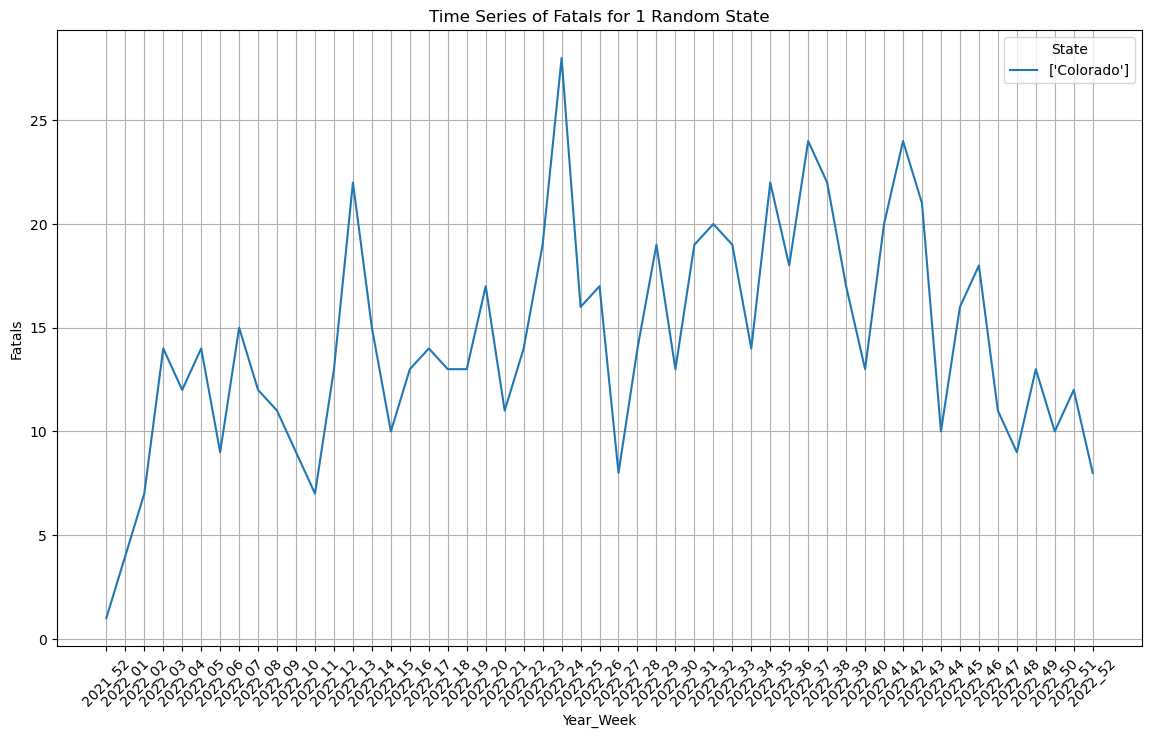

In [82]:
# Selecciona 3 estados aleatorios sin repetición
state = np.random.choice(abt_pca['State'].unique(), 1, replace=False)

# Crea el gráfico y define el tamaño
plt.figure(figsize=(14, 8))

state_data = abt_pca[abt_pca['State'] == state[0]]  # Filtra los datos del estado actual
state_data = state_data.sort_values(by='Year_Week_dt')  # Ordena los datos por 'Year_Week_dt'
plt.plot(state_data['Year_Week'], state_data['Fatals'], label=state)  # Crea la gráfica de series temporales para el estado actual

# Añade etiquetas a los ejes
plt.xlabel('Year_Week')
plt.ylabel('Fatals')

# Define el título del gráfico
plt.title('Time Series of Fatals for 1 Random State')

# Define la leyenda con el nombre de cada estado
plt.legend(title='State')

# Rota las etiquetas del eje X para mejorar la legibilidad
plt.xticks(rotation=45)

# Añade una cuadrícula para facilitar la visualización
plt.grid(True)

# Muestra el gráfico
plt.show()

### Model training

In [84]:
abt_for_train = pd.DataFrame()

for state_to_analyze in abt_pca.State.unique():
    # Define las columnas
    target_column = 'Fatals' # Se define la columna que contiene el valor objetivo (target) a predecir
    #feature_columns = [f'X{i}' for i in range(1, 162)] #  Se crea una lista con los nombres de las columnas de características (features), desde X1 hasta X100
    feature_columns = abt_pca.columns.drop(['Year_Week', 'State', 'Year', 'Week', 'Year_Week_dt'])
    state_column = 'State' # Se define la columna que contiene el nombre del estado
    #state_to_analyze = 'California'  # Se define el estado que se desea analizar (se puede cambiar por otro estado)

    #  Filtra el DataFrame original (abt_pca) para quedarse solo con las filas del estado deseado
    state_df = abt_pca[abt_pca[state_column] == state_to_analyze]

    # Crea una nueva columna para cada característica con el promedio móvil a 8 semanas
    for col in feature_columns:
        state_df[f'{col}_ma8'] = state_df[col].shift(1).rolling(window=8).mean()

    # Elimina las filas que contengan valores NaN creados por el cálculo del promedio móvil
    state_df.dropna(inplace=True)

    # Normaliza las variables con una instancia de StandardScaler
    #scaler = StandardScaler()
    #state_df[[f'{col}_ma8' for col in feature_columns]] = scaler.fit_transform(state_df[[f'{col}_ma8' for col in feature_columns]])

    abt_for_train = pd.concat([state_df, abt_for_train], axis=0)

C:\Users\perez\AppData\Local\Temp\ipykernel_13476\1413315966.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df[f'{col}_ma8'] = state_df[col].shift(1).rolling(window=8).mean()
C:\Users\perez\AppData\Local\Temp\ipykernel_13476\1413315966.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df[f'{col}_ma8'] = state_df[col].shift(1).rolling(window=8).mean()
C:\Users\perez\AppData\Local\Temp\ipykernel_13476\1413315966.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [85]:
abt_for_train = pd.get_dummies(abt_for_train, columns = ['State'])

In [86]:
abt_for_train['Year'] = abt_for_train['Year_Week'].str[:4].astype(int)
abt_for_train['Week'] = abt_for_train['Year_Week'].str[5:].astype(int)
abt_for_train['Year_Week_dt'] = pd.to_datetime(abt_for_train['Year'].astype(str) + abt_for_train['Week'].astype(str).str.zfill(2) + '0', format='%Y%W%w')

In [87]:
abt_for_train = abt_for_train.sort_values(by='Year_Week_dt')

In [88]:
abt_for_train = abt_for_train.drop(columns=['Year', 'Week', 'Year_Week_dt'])

In [89]:
ma8_columns = [f'{col}_ma8' for col in feature_columns]
state_columns = [col for col in abt_for_train.columns if col.strip().startswith('State')]

# Combina ambas listas de columnas
selected_columns = ma8_columns + state_columns

# Crea el DataFrame X con las columnas seleccionadas
X = abt_for_train[selected_columns]

In [91]:
# Crea un DataFrame y que contiene la columna del valor objetivo (target)
y = abt_for_train[target_column]

In [92]:
# Split train/test en el 30% final de los datos
train_size = int(len(X) * 0.7) # Calcula el tamaño del conjunto de entrenamiento (70% de los datos)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:] # Divide los DataFrames X e Y en conjuntos de entrenamiento (las primeras filas) y prueba (las últimas filas)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:] # Separa los valores del target en entrenamiento y prueba

In [93]:
# Crea y entrena el modelo con una instancia de RandomForestRegressor, un modelo de aprendizaje automático para regresión
model = RandomForestRegressor(n_estimators=15, max_depth=20)
model.fit(X_train, y_train) # Entrena el modelo con los datos de entrenamiento

RandomForestRegressor(max_depth=20, n_estimators=15)

In [94]:
# Realiza predicciones sobre el conjunto de prueba utilizando el modelo entrenado
y_pred = model.predict(X_test)

In [96]:
# Calcula el error cuadrático medio (MSE) entre los valores reales del target en el conjunto de prueba y las predicciones
mse = mean_squared_error(y_test, y_pred)

# Calcula el error absoluto medio (MAE) entre los valores reales del target en el conjunto de prueba y las predicciones
mae = mean_absolute_error(y_test, y_pred)

# Calcula el coeficiente de determinación (R²) entre los valores reales del target en el conjunto de prueba y las predicciones
r2 = r2_score(y_test, y_pred)

In [97]:
mse, mae, r2

(39.126231746772255, 4.316824962339874, 0.893762790616679)

In [98]:
# Crear una instancia de StandardScaler
scaler = StandardScaler()

# Ajustar el scaler y transformar los datos
X_scaled = scaler.fit_transform(X)

# Convertir el resultado de nuevo a un DataFrame para una mejor interpretación
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_columns)

In [99]:
# Split train/test en el 30% final de los datos
train_size = int(len(X) * 0.7) # Calcula el tamaño del conjunto de entrenamiento (70% de los datos)
X_train, X_test = X_scaled_df.iloc[:train_size], X_scaled_df.iloc[train_size:] # Divide los DataFrames X e Y en conjuntos de entrenamiento (las primeras filas) y prueba (las últimas filas)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:] # Separa los valores del target en entrenamiento y prueba

In [100]:
# Crea y entrena el modelo con una instancia de RandomForestRegressor, un modelo de aprendizaje automático para regresión
model = RandomForestRegressor(n_estimators=15, max_depth=20)
model.fit(X_train, y_train) # Entrena el modelo con los datos de entrenamiento

RandomForestRegressor(max_depth=20, n_estimators=15)

In [101]:
# Realiza predicciones sobre el conjunto de prueba utilizando el modelo entrenado
y_pred = model.predict(X_test)

In [102]:
# Calcula el error cuadrático medio (MSE) entre los valores reales del target en el conjunto de prueba y las predicciones
mse = mean_squared_error(y_test, y_pred)

# Calcula el error absoluto medio (MAE) entre los valores reales del target en el conjunto de prueba y las predicciones
mae = mean_absolute_error(y_test, y_pred)

# Calcula el coeficiente de determinación (R²) entre los valores reales del target en el conjunto de prueba y las predicciones
r2 = r2_score(y_test, y_pred)

In [103]:
mse, mae, r2

(37.23900180134635, 4.284574166692947, 0.8988870776720821)

In [104]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train) #X_train normalizado
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


c:\Users\perez\anaconda3\envs\final_project\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
551 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\perez\anaconda3\envs\final_project\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\perez\anaconda3\envs\final_project\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\perez\anaconda3\envs\final_project\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    va

In [105]:
# Calcula el error cuadrático medio (MSE) entre los valores reales del target en el conjunto de prueba y las predicciones
mse = mean_squared_error(y_test, y_pred)

# Calcula el error absoluto medio (MAE) entre los valores reales del target en el conjunto de prueba y las predicciones
mae = mean_absolute_error(y_test, y_pred)

# Calcula el coeficiente de determinación (R²) entre los valores reales del target en el conjunto de prueba y las predicciones
r2 = r2_score(y_test, y_pred)

In [106]:
mse, mae, r2

(53.083337815477485, 5.3751998564719266, 0.8558658623000751)

### Feature importance

In [113]:
feature_importances = best_model.feature_importances_

In [114]:
feature_importances_df = pd.DataFrame({ 'Feature': selected_columns, 'Importance': feature_importances })

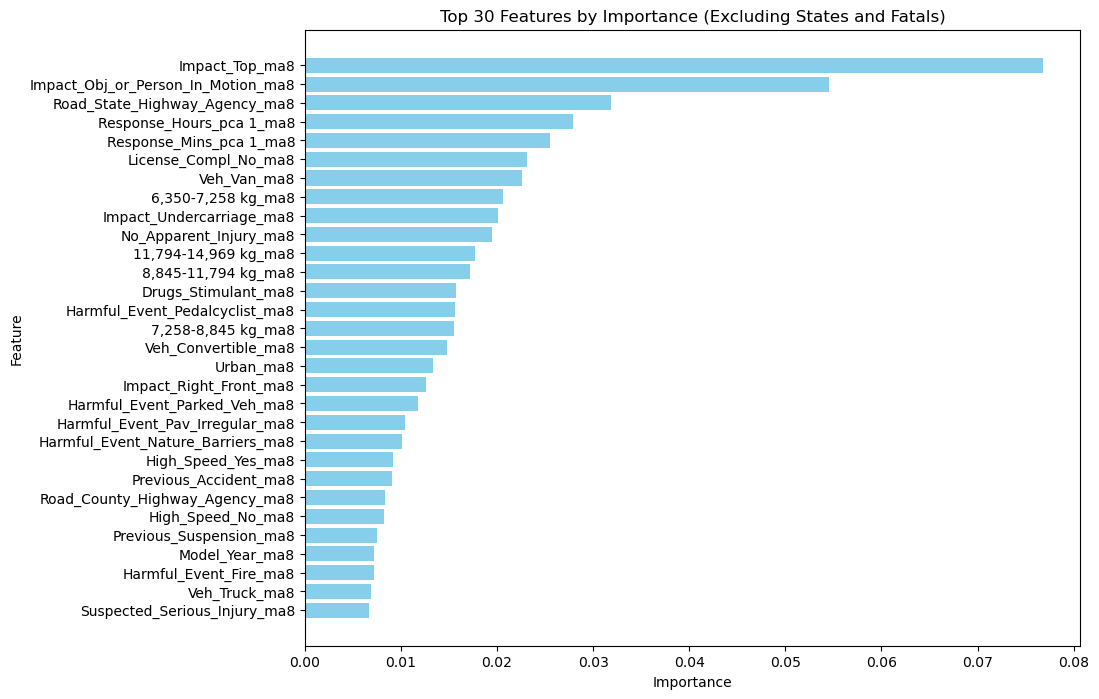

In [116]:
# Ordena el DataFrame por la columna 'Importance' de mayor a menor
sorted_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Excluye las columnas que son de estados o contienen 'Fatals'
non_state_or_fatals_columns = sorted_df[~sorted_df['Feature'].str.startswith('State_') & ~sorted_df['Feature'].str.contains('Fatals')]

# Selecciona los primeros 30 Feature excluyendo los estados y 'Fatals'
top_30_non_state_or_fatals_df = non_state_or_fatals_columns.head(30)

# Crea el gráfico de barras
plt.figure(figsize=(10, 8))
plt.barh(top_30_non_state_or_fatals_df['Feature'], top_30_non_state_or_fatals_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Features by Importance (Excluding States and Fatals)')
plt.gca().invert_yaxis()  # Invertir el eje y para que el Feature con mayor Importance esté arriba
plt.show()

### Next 8 weeks Fatals forecast to .csv

In [112]:
total_final_predictions = pd.DataFrame()

In [117]:
for state_col in state_columns:

    state = state_col.split('_')[1]  # Extraer el nombre del estado

    state_data = abt_for_train[abt_for_train['State_' + state] == True]
    state_data['Year'] = state_data['Year_Week'].str[:4].astype(int)
    state_data['Week'] = state_data['Year_Week'].str[5:7].astype(int)
    state_data['Year_Week_dt'] = pd.to_datetime(state_data['Year'].astype(str) + state_data['Week'].astype(str).str.zfill(2) + '0', format='%Y%W%w')
    last_date = state_data['Year_Week_dt'].max()

    for i in range(1, 9):

        # Crea un dataframe para almacenar las predicciones futuras
        future_predictions_2 = pd.DataFrame()

        # La fecha de la semana a predecir
        next_week_date = last_date + timedelta(weeks=i)

        # Crea un nuevo registro para la próxima semana
        new_record = {}

        # Añade el promedio móvil de 8 semanas para cada característica
        for col in feature_columns:
            new_record[f'{col}_ma8'] = state_data[col].shift(1).rolling(window=8).mean().iloc[-1]

        # Añade las columnas de estado binario
        for col in state_columns:
            new_record[col] = 1 if col == state_col else 0

        # Añade la fecha de la semana
        new_record['Year_Week_dt'] = next_week_date

        # Convierte el registro en dataframe y lo añade al dataframe del estado
        new_record_df = pd.DataFrame([new_record])
        state_data_temp = pd.concat([state_data, new_record_df], ignore_index=True)

        # Escala las características (utiliza scaler entrenado anteriormente)
        scaled_features = scaler.transform(state_data_temp[selected_columns].iloc[-1:].values)

        # Realiza la predicción
        prediction = best_model.predict(scaled_features)

        # Añade la predicción al nuevo registro
        new_record['Prediction'] = prediction[0]

        # Añade la predicción a las predicciones futuras
        future_predictions_2 = pd.concat([future_predictions_2, pd.DataFrame([new_record])])

        future_predictions_2.columns = future_predictions_2.columns.str.replace('_ma8', '')

        abt_for_artificial_predictions = pd.concat([state_data, future_predictions_2])

        abt_for_artificial_predictions['Year_Week'] = abt_for_artificial_predictions['Year_Week_dt'].dt.isocalendar().year.astype(str) + '_' + abt_for_artificial_predictions['Year_Week_dt'].dt.isocalendar().week.astype(str).str.zfill(2)

        abt_for_artificial_predictions['State'] = state[0]

        abt_for_artificial_predictions = abt_for_artificial_predictions.fillna(0)

        state_data = abt_for_artificial_predictions

    total_final_predictions = pd.concat([state_data, total_final_predictions], axis=0)


C:\Users\perez\AppData\Local\Temp\ipykernel_13476\3786574337.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_data['Year'] = state_data['Year_Week'].str[:4].astype(int)
C:\Users\perez\AppData\Local\Temp\ipykernel_13476\3786574337.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_data['Week'] = state_data['Year_Week'].str[5:7].astype(int)
C:\Users\perez\AppData\Local\Temp\ipykernel_13476\3786574337.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [124]:
# Crea un backup con los resultados por si se daña a posteriori
back_up_total_final_predictions = total_final_predictions.copy()

In [125]:
# Obtiene el nombre de las columnas de estado
state_columns = total_final_predictions.columns[321:372]

In [126]:
# Crea una nueva columna con todos los estados en los que hay un 1
total_final_predictions['State'] = total_final_predictions[state_columns].idxmax(axis=1)

In [127]:
# Modifica el nombre de los estados, eliminando State_
total_final_predictions['State'] = total_final_predictions.State.str.replace('State_', '')

In [128]:
# Cuando la Predicción es mayor que 0, Fatals se modifica a 0
total_final_predictions.loc[total_final_predictions['Prediction'] > 0, 'Fatals'] = 0

In [129]:
# Selecciona solo las columnas que interesan para la graficación
total_final_predictions = total_final_predictions[['Year_Week', 'State', 'Fatals', 'Prediction']]

In [135]:
# Exporta el dataframe de predicciones a un .csv

# Obtiene la ruta absoluta del directorio base del proyecto
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))

# Define el directorio donde se guarda el archivo .csv
dataout_directory = os.path.join(project_root, 'final_project', 'data', 'dataout')

# Asegura que el directorio existe y, si no, lo crea
os.makedirs(dataout_directory, exist_ok=True)

# Define la ruta completa del archivo .csv
file_path = os.path.join(dataout_directory, 'total_final_predictions.csv')

# Exporta el dataframe a un archivo .csv
total_final_predictions.to_csv(file_path, index=False)

print(f'Dataframe successfully exported to {file_path}')

Dataframe successfully exported to c:\Users\perez\OneDrive\Documentos\GitHub\Proyectos\final_project\final_project\data\dataout\total_final_predictions.csv
